In [548]:
import geopandas as gpd
import xarray as xr
import pandas as pd
from operator import itemgetter
import numpy as np
import scipy.stats as stats
import rioxarray as rioxr
from rasterio.enums import Resampling

from metloom.pointdata import SnotelPointData, MesowestPointData
import datetime as dt
import matplotlib.pyplot as plt
from metloom.variables import SnotelVariables, SensorDescription, MesowestVariables
import shapely
import contextily as cx

import requests
import json
from dataretrieval import nwis
# used this to access the metadata for CO mesowest stations
# response = requests.get('https://api.synopticdata.com/v2/stations/metadata?&token=bd62c79f64c9433daf0f2f23a0bc1f7e&output=json&state=CO').text

### Import HCDN Gaging stations and data

In [193]:
ucrb_hcdn_stations = gpd.read_file('./ucrb_hcdn_stations.json')
ucrb_hcdn_stations['geometry'] = gpd.GeoSeries(ucrb_hcdn_stations['geometry']).map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))
ucrb_hcdn_stations = ucrb_hcdn_stations.set_crs(epsg='4326')

station_ids = ['0'+str(station) for station in ucrb_hcdn_stations['station_id']]

hcdn_streamflow_df = nwis.get_dv(sites=station_ids, start='1986-10-01', end='2021-09-30')


In [225]:
df = hcdn_streamflow_df[0]['00060_Mean'].reset_index()


df['datetime']=[d.date() for d in df['datetime']]
df['datetime']= pd.to_datetime(df['datetime'])
df = df.set_index(['site_no','datetime'])
hcdn_q_ds = df.to_xarray()

In [302]:
hcdn_q_spring_summer_ds = hcdn_q_ds.where(hcdn_q_ds.datetime.dt.month.isin([4,5,6,7,8,9])).to_dataframe().dropna().to_xarray()
hcdn_q_spring_summer_mean_ds = hcdn_q_spring_summer_ds.groupby('datetime.year').mean()

In [542]:
norm_hcdn_mean_ds = (hcdn_q_spring_summer_mean_ds - hcdn_q_spring_summer_mean_ds.mean(dim='year'))/hcdn_q_spring_summer_mean_ds.std(dim='year')
norm_hcdn_mean_ds = norm_hcdn_mean_ds.sel(year=slice(1987,2021))

#### Reproject to 13N UTM Zone

In [5]:
ucrb_hcdn_stations_rpj = ucrb_hcdn_stations.to_crs(epsg='32613')

### Import HCDN Basins and reproject to 13N UTM Zone

In [23]:
ucrb_hcdn_basins = gpd.read_file('./ucrb_hcdn_polygons.json')
ucrb_hcdn_basins_rpj = ucrb_hcdn_basins.to_crs(epsg='32613')
ucrb_hcdn_basins_rpj_centroids = ucrb_hcdn_basins_rpj.geometry.centroid

### Pull in all SNTL metadata and MesoNet metadata

In [47]:
AWDB_API_DOMAIN = "https://api.snowdata.info"
sntl_meta_url = f"{AWDB_API_DOMAIN}/stations/getMeta?network=SNTL&format=geojson"

# Get the data and rename everything to match the snow ex columns
gdf_sntl = gpd.read_file(sntl_meta_url).rename(
    columns={"name": "site_name", "stationTriplet": "site_id"}
)
gdf_sntl = gdf_sntl.to_crs(epsg='32613')

In [91]:
mesowest_df = pd.read_json('./mesowest_co_metadata.json')
mesowest_gdf = gpd.GeoDataFrame(mesowest_df,geometry=gpd.points_from_xy(mesowest_df.LONGITUDE, mesowest_df.LATITUDE), crs='4326')
mesowest_gdf_rpj = mesowest_gdf.to_crs(epsg='32613')

In [133]:
start_dates = [dt.datetime.strptime(str(s['start'])[:-1], '%Y-%m-%dT%H:%M:%S') if str(s['start']) !='None' else None for s in mesowest_gdf_rpj['PERIOD_OF_RECORD'] ]
start_date_series = pd.Series(start_dates, index=mesowest_gdf_rpj.index)

In [137]:
mswst_start_pre_2000 = start_date_series[start_date_series<dt.datetime(2000,1,1)].index


In [138]:
mesowest_gdf_rpj = mesowest_gdf_rpj.query("STATUS=='ACTIVE'")
mesowest_gdf_rpj = mesowest_gdf_rpj.loc[mswst_start_pre_2000]

In [153]:
nearest_sntl = {}
nearest_mswst = {}

for i,basin in enumerate(ucrb_hcdn_basins_rpj_centroids):
    # calculate distances between br_geom and the points
    # {index: distance, index: distance, ...} / r[0]: index, r[1]: row in DataFrame
    dist_sntl = {r[1]['site_id']: r[1]['geometry'].distance(basin) for r in gdf_sntl[gdf_sntl['site_id'].str.contains('CO')][['site_id','geometry']].iterrows()}
    dist_mswst = {r[1]['STID']: r[1]['geometry'].distance(basin) for r in mesowest_gdf_rpj[['STID','geometry']].iterrows()}
    # get the nearest point index
    idx_sntl = sorted(dist_sntl.items(), key=itemgetter(1))[:2]
    idx_mswst = sorted(dist_mswst.items(), key=itemgetter(1))[:2]
    #get the point by index
    nearest_sntl[ucrb_hcdn_basins_rpj.iloc[i]['GAGE_ID']] = [site[0] for site in idx_sntl]
    nearest_mswst[ucrb_hcdn_basins_rpj.iloc[i]['GAGE_ID']] = [site[0] for site in idx_mswst]


In [140]:
mswst_pt = MesowestPointData(station_id=list(nearest_mswst.values())[0], name='Unknown')

In [143]:
df = mswst_pt.get_daily_data(start_date=dt.date(2020,10,1), end_date=dt.date(2020,10,2), variables=[MesowestVariables.TEMP])

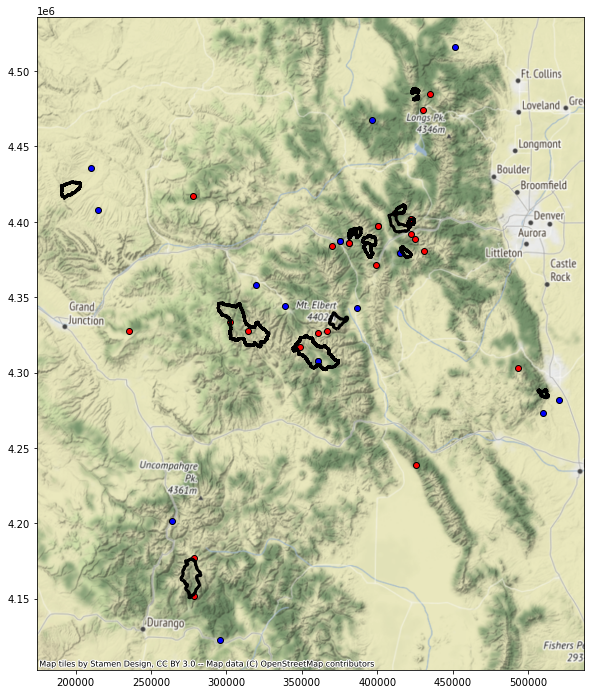

In [162]:

ax=ucrb_hcdn_basins_rpj.boundary.plot(color='k', linewidth=3, label='HCDN Boundaries', figsize=(12,12),edgecolor='k')

#Add in hospitals as points
gdf_sntl[gdf_sntl['site_id'].isin([val[0] for val in list(nearest_sntl.values())])].plot(c="r", alpha=1, ec='k', label='SNOTEL Sites', ax=ax)
gdf_sntl[gdf_sntl['site_id'].isin([val[1] for val in list(nearest_sntl.values())])].plot(c="r", alpha=1, ec='k', ax=ax)
mesowest_gdf_rpj[mesowest_gdf_rpj['STID'].isin([val[0] for val in list(nearest_mswst.values())])].plot(c="blue", alpha=1, ec='k', label='MESOWEST Sites', ax=ax)
mesowest_gdf_rpj[mesowest_gdf_rpj['STID'].isin([val[1] for val in list(nearest_mswst.values())])].plot(c="blue", alpha=1, ec='k', ax=ax)
#Now adding in the basemap imagery
cx.add_basemap(ax, crs=ucrb_hcdn_basins_rpj.crs.to_string(), source=cx.providers.Stamen.Terrain)


### Request SNTL data

In [537]:
closest_sntl_swe_ds = xr.open_dataset('./hcdn_sntl_20220930.nc')
closest_sntl_april_1_swe = closest_sntl_swe_ds.where((closest_sntl_swe_ds.Date.dt.month==4)&(closest_sntl_swe_ds.Date.dt.day==1)).to_dataframe().dropna().to_xarray()
norm_closest_sntl_april_1_swe = (closest_sntl_april_1_swe-closest_sntl_april_1_swe.mean(dim='Date'))/closest_sntl_april_1_swe.std(dim='Date')
norm_closest_sntl_april_1_swe = norm_closest_sntl_april_1_swe.sortby('Date')
norm_closest_sntl_april_1_swe = norm_closest_sntl_april_1_swe.sel(Date=slice('1987-4-1','2021-4-1'))
norm_closest_sntl_april_1_swe['Date'] = norm_closest_sntl_april_1_swe['Date'].dt.year

if 'datetime' in norm_hcdn_mean_ds.dims:
    norm_hcdn_mean_ds['datetime'] = norm_hcdn_mean_ds['datetime'].dt.year-1

In [538]:
second_sntl_swe_ds = xr.open_dataset('./hcdn_second_closest_20220930.nc')
second_sntl_april_1_swe = second_sntl_swe_ds.where((second_sntl_swe_ds.Date.dt.month==4)&(second_sntl_swe_ds.Date.dt.day==1)).to_dataframe().dropna().to_xarray()
norm_second_sntl_april_1_swe = (second_sntl_april_1_swe-second_sntl_april_1_swe.mean(dim='Date'))/second_sntl_april_1_swe.std(dim='Date')
norm_second_sntl_april_1_swe = norm_second_sntl_april_1_swe.sortby('Date')
norm_second_sntl_april_1_swe = norm_second_sntl_april_1_swe.sel(Date=slice('1987-4-1','2021-4-1'))
norm_second_sntl_april_1_swe['Date'] = norm_second_sntl_april_1_swe['Date'].dt.year

In [539]:
def linreg_output(swe, q):
    slope, intercept, rvalue, pvalue,stderr  = stats.linregress(swe, q)

    alpha = 0.05
    c = (1 - alpha)

    # Create regression line and residuals
    X = swe
    y_predicted = intercept + slope*X
    residual = (q-y_predicted)

    # Setup 
    n = X.size                                               
    dof = n - 2
    t = stats.t.ppf(c, dof) 

    # sum of squared errors
    sse = np.sum(residual**2)

    # total sum of squares (y)
    sst = np.sum( (q - np.mean(q))**2 )

    # total sum of squares (x)
    sst_x = np.sum( (X - np.mean(X))**2 )

    # correlation coefficient
    r_squared = 1 - sse/sst

    # standard error of regression
    s = np.sqrt(sse/(n-2))

    # an array of x values
    p_x = np.linspace(X.min(),X.max(),100)

    # using our model parameters to predict y values
    p_y = intercept + slope*p_x

    # compute error of prediction for each p_x
    sigma_ep = np.sqrt( s**2 * (1+ 1/n + ( ( n*(p_x-X.mean(axis=None))**2 ) / ( n*np.sum(X**2) - np.sum(X)**2 ) ) ) )
    # set our confidence interval

    p_y_lower = p_y - t * sigma_ep
    p_y_upper = p_y + t * sigma_ep
    return X, intercept, slope, residual, r_squared

Using Far Location for 09306242


Text(-0.01, 0.5, 'Normalized Apr1 - Sep30 Q')

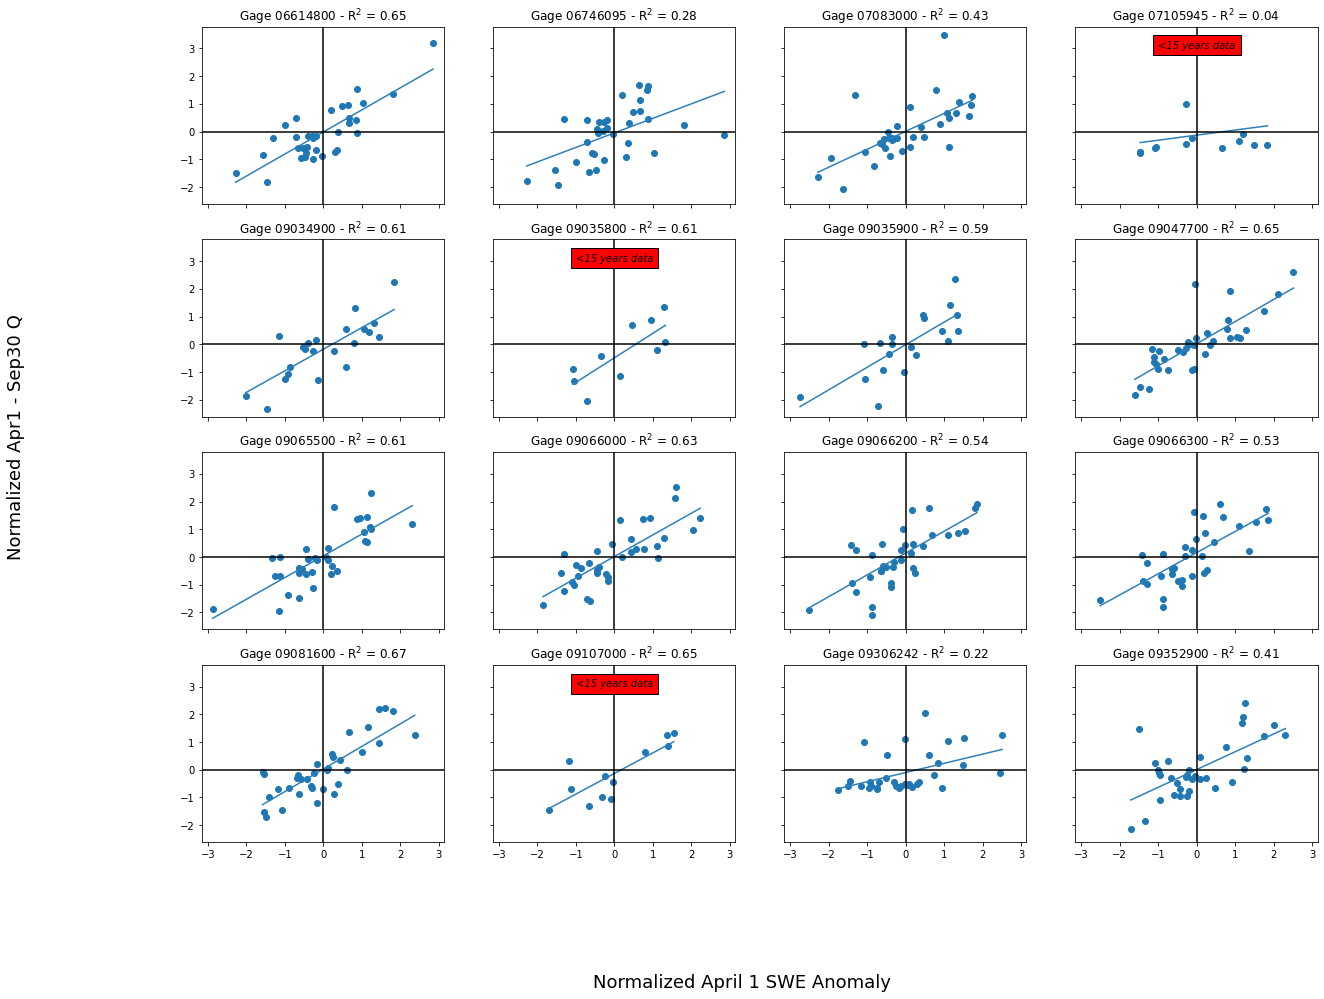

In [544]:
colors = ['#2c7fb8','#7fcdbb']
residuals = {}
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(20,15), sharex=True, sharey=True)
axs=axs.ravel()

for i,loc in enumerate(list(norm_hcdn_mean_ds.site_no.values)):
    # Set axis for plotting
    ax=axs[i]
    # get nearest sntl site
    sntl_site_close = nearest_sntl[loc][0]
    sntl_site_far = nearest_sntl[loc][1]

    # Calculate normalized
    if len(normalized_april_1_swe.index) >= 14:
        sntl_site = sntl_site_close
        normalized_april_1_swe = norm_closest_sntl_april_1_swe.sel(Location=sntl_site)['WTEQ'].to_dataframe().dropna() 
    else:
       print(f'Using Far Location for {loc}')
       sntl_site = sntl_site_far
       normalized_april_1_swe = norm_second_sntl_april_1_swe.sel(Location=sntl_site)['WTEQ'].to_dataframe().dropna() 
    
    normalized_q_apr1_sep30 = norm_hcdn_mean_ds.sel(site_no=loc)['00060_Mean'].to_dataframe().dropna()
    tmp_df = normalized_q_apr1_sep30.merge(normalized_april_1_swe, left_index=True, right_index=True)
    tmp_df = tmp_df.where(np.abs(tmp_df['WTEQ'] - tmp_df['00060_Mean']) <3).dropna()
    # Run linreg function to get output
    X, intercept, slope, residual, r_squared = linreg_output(tmp_df['WTEQ'].values, tmp_df['00060_Mean'].values)
    residuals[loc] = pd.Series(residual, index=tmp_df.index)

    # Plotting up each location
    ax.scatter(tmp_df['WTEQ'], tmp_df['00060_Mean'])
    ax.plot([X.min(),X.max()], intercept+slope*np.array([X.min(),X.max()]), color=colors[0], label='Best-Fit Line', color='red')
    if len(tmp_df.index) < 15:
        ax.text(-1, 3, '<15 years data', style='italic',
        bbox={'facecolor': 'red', 'alpha': 1, 'pad': 5})
    ax.axhline(0, color='k')
    ax.axvline(0, color='k')
    ax.set_title(f'Gage {loc} - R$^2$ = {round(r_squared,2)}')
fig.text(0.5, -0.01, 'Normalized April 1 SWE Anomaly', ha='center', size=18)
fig.text(-0.01, 0.5, 'Normalized Apr1 - Sep30 Q', va='center', rotation='vertical', size=18)

In [545]:
ordered_idx = {}
residual_df = pd.DataFrame(residuals)
for col in residual_df.columns:
    ordered_idx[col] = residual_df[col].sort_values(na_position='last').index
    ordered_idx[f'{col}_flag'] = residual_df[col].sort_values(na_position='last').isna().reset_index(drop=True)

ordered_idx_df = pd.DataFrame(ordered_idx)

<AxesSubplot:>

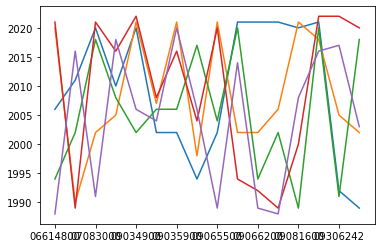

In [486]:
ordered_idx_df[ordered_idx_df.columns[(~ordered_idx_df.columns.str.contains('flag'))]].loc[0].plot()
ordered_idx_df[ordered_idx_df.columns[(~ordered_idx_df.columns.str.contains('flag'))]].loc[1].plot()
ordered_idx_df[ordered_idx_df.columns[(~ordered_idx_df.columns.str.contains('flag'))]].loc[2].plot()
ordered_idx_df[ordered_idx_df.columns[(~ordered_idx_df.columns.str.contains('flag'))]].loc[3].plot()
ordered_idx_df[ordered_idx_df.columns[(~ordered_idx_df.columns.str.contains('flag'))]].loc[4].plot()

In [546]:
good_col_list = []
for i,col in enumerate(ordered_idx_df.columns):
    if i % 2 != 0:
        if ordered_idx_df[col].sum() <= 5:
            good_col_list.extend([ordered_idx_df.columns[i-1]])

In [547]:
ordered_idx_df[good_col_list].loc[0:10]

,06614800,06746095,07083000,09047700,09065500,09066000,09066200,09066300,09081600,09306242,09352900
0,2006,2011,2020,1994,2002,2021,2021,2021,2020,1992,2002
1,2020,1990,2002,1998,2021,2002,2002,2002,2021,2005,1989
2,1994,2002,2018,2017,2004,2020,1994,2006,1989,1991,2018
3,2021,1989,2021,2004,2020,1994,1992,1989,2000,2017,2020
4,1988,2016,1991,2006,1989,2014,1989,1988,2008,2006,2003
5,2002,2006,1988,2002,2018,1998,1988,1992,2018,2003,1992
6,1989,2021,2008,2020,1996,2006,1997,2020,1996,2004,2000
7,2001,1996,2009,2019,1988,1988,2018,1994,2002,1989,2021
8,2007,2020,2016,2008,2014,2008,2006,1990,1988,1994,1996
9,1992,2012,2006,2012,2007,1996,2005,1987,2013,2009,2012


### Signals of Fall Soil Moisture

In [556]:
cbrfc_sm = rioxr.open_rasterio('../../data/cbrfc_fall_soil_product.nc')
cbrfc_sm = cbrfc_sm.rio.set_crs('EPSG:4326')
cbrfc_sm_rpj = cbrfc_sm.rio.reproject(ucrb_hcdn_basins_rpj.crs, resampling=Resampling.cubic)

In [570]:
# Normalized anomaly of basin mean fall soil moisture percent from normal
hcdn_soil_moisture = {}
for row, basin in ucrb_hcdn_basins_rpj.iterrows():
    # clip to basin 
    print(f'Working on {basin.GAGE_ID}')
    tmp = gpd.GeoDataFrame(basin).T
    try:
        basin_cbrfc_sm_rpj = cbrfc_sm_rpj.rio.clip(tmp.geometry)
        basin_cbrfc_sm_rpj_basin_mean = basin_cbrfc_sm_rpj.sel(year=slice(1986,2021)).mean(dim='x', skipna=True).mean(dim='y', skipna=True)
        norm_er_cbrfc_rpj_basin_mean = (basin_cbrfc_sm_rpj_basin_mean-basin_cbrfc_sm_rpj_basin_mean.mean())/basin_cbrfc_sm_rpj_basin_mean.std()
        hcdn_soil_moisture[basin.GAGE_ID] = norm_er_cbrfc_rpj_basin_mean.values
    except:
        print('No Overlapping Data...')
        pass

Working on 06614800


c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Working on 06746095


c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Working on 07083000


c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Working on 07105945
No Overlapping Data...
Working on 09034900
Working on 09035800
Working on 09035900
Working on 09047700
Working on 09065500
Working on 09066000
Working on 09066200
Working on 09066300
Working on 09081600
Working on 09107000
Working on 09306242


c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Working on 09352900


In [586]:
ordered_sm = {}
hcdn_fall_soil_moisture_anomaly = pd.DataFrame(hcdn_soil_moisture).dropna(axis=1).set_index(np.arange(1986,2022,1))
for col in hcdn_fall_soil_moisture_anomaly.columns:
    ordered_sm[col] = hcdn_fall_soil_moisture_anomaly[col].sort_values(na_position='last').index

ordered_sm_df = pd.DataFrame(ordered_sm)

In [587]:
ordered_sm_df

,09034900,09035800,09035900,09047700,09065500,09066000,09066200,09066300,09081600,09107000,09352900
0,2002,2002,2002,2002,2018,2018,2018,2018,2012,2002,2020
1,2020,2018,2018,2018,2020,2020,1988,1987,2020,2012,2018
2,2018,2020,2020,2020,1988,1987,2020,1988,2000,2020,2019
3,1987,2012,2012,2012,1987,1988,1987,2020,2002,2018,2012
4,2015,1988,1988,1987,2016,2012,2012,2012,1992,2000,2002
5,2012,1987,1987,1988,2015,2002,2002,2021,2018,1988,2000
6,1988,2016,1992,2004,2021,2021,2021,2002,2016,2004,2009
7,2016,1992,2016,1992,1994,2016,2016,1989,1988,1991,2004
8,1994,1994,1994,1991,1989,1989,1989,2016,1989,2001,2021
9,2019,2015,1989,2021,2012,2015,1994,1994,1987,1992,2001
